In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

sns.set_style("white")
sns.set_context('notebook')

Using TensorFlow backend.


In [3]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [4]:
training_data.groupby('call').size()

call
a    13745
f     1600
g     3946
s    17781
dtype: int64

In [5]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [6]:
X.shape

(37072, 67)

In [7]:
Y.shape

(37072, 4)

In [8]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [9]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=67, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [11]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [12]:
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')

Epoch 1/10
33364/33364 [==============================] - 21s - loss: 0.8710 - acc: 0.6177    
Epoch 2/10
33364/33364 [==============================] - 19s - loss: 0.7603 - acc: 0.7050    
Epoch 3/10
33364/33364 [==============================] - 17s - loss: 0.7329 - acc: 0.7132    
Epoch 4/10
33364/33364 [==============================] - 14s - loss: 0.7192 - acc: 0.7176    
Epoch 5/10
33364/33364 [==============================] - 17s - loss: 0.7112 - acc: 0.7197    
Epoch 6/10
33364/33364 [==============================] - 15s - loss: 0.7055 - acc: 0.7209    
Epoch 7/10
33364/33364 [==============================] - 17s - loss: 0.7015 - acc: 0.7220    
Epoch 8/10
33364/33364 [==============================] - 15s - loss: 0.6981 - acc: 0.7233    
Epoch 9/10
33364/33364 [==============================] - 16s - loss: 0.6951 - acc: 0.7242    
Epoch 10/10
33364/33364 [==============================] - 16s - loss: 0.8741 - acc: 0.6205    
Epoch 2/10
33364/33364 [=========================

33365/33365 [==============================] - 18s - loss: 0.7623 - acc: 0.7034    
Epoch 3/10
33365/33365 [==============================] - 18s - loss: 0.7348 - acc: 0.7135    
Epoch 4/10
33365/33365 [==============================] - 19s - loss: 0.7214 - acc: 0.7180    
Epoch 5/10
33365/33365 [==============================] - 18s - loss: 0.7131 - acc: 0.7196    
Epoch 6/10
33365/33365 [==============================] - 20s - loss: 0.7076 - acc: 0.7212    
Epoch 7/10
33365/33365 [==============================] - 20s - loss: 0.7032 - acc: 0.7217    
Epoch 8/10
33365/33365 [==============================] - 21s - loss: 0.7002 - acc: 0.7206    
Epoch 9/10
33365/33365 [==============================] - 21s - loss: 0.6968 - acc: 0.7237    
Epoch 10/10
33365/33365 [==============================] - 18s - loss: 0.8741 - acc: 0.6218    
Epoch 2/10
33365/33365 [==============================] - 21s - loss: 0.7633 - acc: 0.7047    
Epoch 3/10
33365/33365 [==============================] - 22

In [13]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [14]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [15]:
metrics.accuracy_score(Y, predicted_transformed)

0.72156883901596891

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [16]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.68      0.73      0.70     13745
          1       0.47      0.13      0.21      1600
          2       0.60      0.51      0.55      3946
          3       0.78      0.81      0.80     17781

avg / total       0.71      0.72      0.71     37072



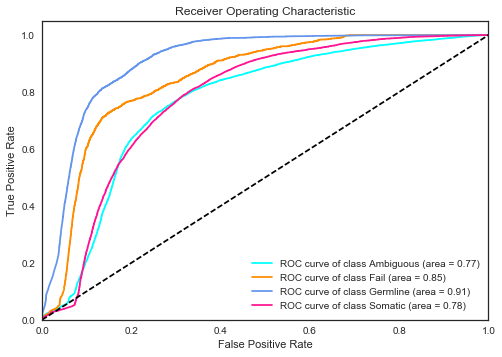

In [17]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Germline', 3: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [18]:
prob_df = pd.DataFrame(probabilities, columns=['Ambiguous','Fail',
                                               'Germline', 'Somatic'])

# Normalize the values by dividing each value by the sum of its columns
prob_df_norm = prob_df.div(prob_df.sum(axis=1), axis=0)

label_index = pd.DataFrame(Y, columns=['Ambiguous','Fail',
                                          'Germline','Somatic'], dtype=bool)

positive_probabilities = prob_df_norm[label_index].unstack().dropna().values

positive_counts, bins = np.histogram(positive_probabilities, bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

negative_probabilities = prob_df_norm[~label_index].unstack().dropna()

negative_counts, _ = np.histogram(negative_probabilities, bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

pct_positive = positive_counts / (positive_counts + negative_counts)

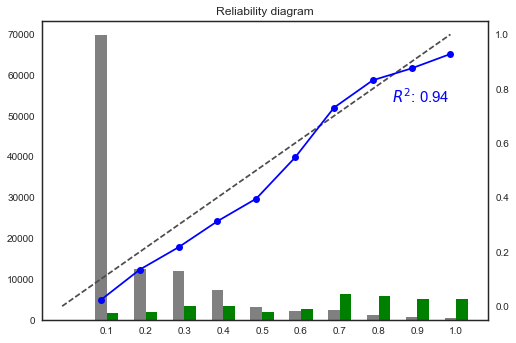

In [19]:
width = 0.03       # the width of the bars

fig, ax1 = plt.subplots()
rects1 = ax1.bar(bins[1:], negative_counts, width, color='grey')

rects2 = ax1.bar(bins[1:] + width, positive_counts, width, color='green')

# add some text for labels, title and axes ticks

ax1.set_title('Reliability diagram')
ax1.set_xticks(bins[1:] + width / 2)
ax1.set_xticklabels(bins[1:])
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

# ax1.legend((rects1[0], rects2[0]), ('Neg', 'Pos'), loc=5)

ax2 = ax1.twinx()
ax2.plot(bins, bins, ls="--", c=".3")
r2 = str(round(metrics.r2_score(bins[1:], pct_positive),2))
ax2.plot(bins[1:], pct_positive, "-o", color='blue')
ax2.text(.85,.75,'$R^2$: {0}'.format(r2), color='blue', fontsize=15)


plt.show()

## Refactor to single class classifier 
Manual reviewer's calling variants germline is problematic as the callers that produced the calls are designed to call somatic variants. These germline calls are likely very poor quality and in most analysis streams get thrown out anyway. While 'ambigous' variant exist in a grey area where the reviewer is unsure whether to call the variant somatic or fail. All of these classes (germile, ambiguous, and fail) are treated the same in downstream analysis (thrown out).

In [20]:
training_data.groupby('call').size()

call
a    13745
f     1600
g     3946
s    17781
dtype: int64

In [21]:
training_data['binary_call'] = training_data.call.replace(['a', 'f', 'g'], False)
training_data['binary_call'] = training_data['binary_call'].replace('s', True)

In [22]:
training_data.groupby('binary_call').size()

binary_call
False    19291
True     17781
dtype: int64

In [23]:
# Get Labels
binary_Y = training_data.binary_call.astype(int).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [24]:
X.shape

(37072, 67)

In [25]:
binary_Y.shape

(37072,)

In [26]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(1, input_dim=67, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=10, batch_size=5, verbose=1)

In [28]:
binary_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [29]:
binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=binary_kfold, method='predict_proba')

Epoch 1/10
33364/33364 [==============================] - 29s - loss: 0.5898 - acc: 0.6949    
Epoch 2/10
33364/33364 [==============================] - 24s - loss: 0.5197 - acc: 0.7692    
Epoch 3/10
33364/33364 [==============================] - 21s - loss: 0.4946 - acc: 0.7921    
Epoch 4/10
33364/33364 [==============================] - 22s - loss: 0.4823 - acc: 0.8028    
Epoch 5/10
33364/33364 [==============================] - 22s - loss: 0.4751 - acc: 0.8033    
Epoch 6/10
33364/33364 [==============================] - 22s - loss: 0.4701 - acc: 0.8051    
Epoch 7/10
33364/33364 [==============================] - 22s - loss: 0.4669 - acc: 0.8055    
Epoch 8/10
33364/33364 [==============================] - 20s - loss: 0.4645 - acc: 0.8066    
Epoch 9/10
33364/33364 [==============================] - 23s - loss: 0.4626 - acc: 0.8069    
Epoch 10/10
33364/33364 [==============================] - 22s - loss: 0.5915 - acc: 0.6918    
Epoch 2/10
33364/33364 [=========================

33365/33365 [==============================] - 18s - loss: 0.5219 - acc: 0.7625    
Epoch 3/10
33365/33365 [==============================] - 18s - loss: 0.4976 - acc: 0.7903    
Epoch 4/10
33365/33365 [==============================] - 18s - loss: 0.4856 - acc: 0.7987    
Epoch 5/10
33365/33365 [==============================] - 19s - loss: 0.4782 - acc: 0.8032    
Epoch 6/10
33365/33365 [==============================] - 18s - loss: 0.4737 - acc: 0.8045    
Epoch 7/10
33365/33365 [==============================] - 18s - loss: 0.4702 - acc: 0.8039    
Epoch 8/10
33365/33365 [==============================] - 19s - loss: 0.4680 - acc: 0.8052    
Epoch 9/10
33365/33365 [==============================] - 18s - loss: 0.4661 - acc: 0.8054    
Epoch 10/10
33365/33365 [==============================] - 18s - loss: 0.5914 - acc: 0.6928    
Epoch 2/10
33365/33365 [==============================] - 17s - loss: 0.5216 - acc: 0.7647    
Epoch 3/10
33365/33365 [==============================] - 18

In [30]:
binary_probabilities

array([[ 0.83843452,  0.16156547],
       [ 0.02316564,  0.97683436],
       [ 0.04626358,  0.95373642],
       ..., 
       [ 0.59686291,  0.40313706],
       [ 0.4630214 ,  0.5369786 ],
       [ 0.17671436,  0.82328564]], dtype=float32)

In [31]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [32]:
metrics.accuracy_score(binary_Y, predicted)

0.80616098403107461

In [33]:
print(metrics.classification_report(binary_Y, predicted))

             precision    recall  f1-score   support

          0       0.81      0.82      0.82     19291
          1       0.80      0.79      0.80     17781

avg / total       0.81      0.81      0.81     37072



In [34]:
somatic_prob = binary_probabilities[:,1]

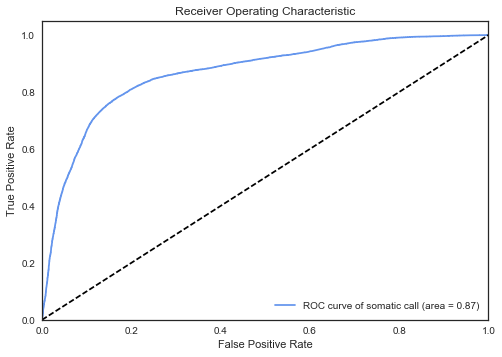

In [35]:
plt.title('Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [38]:
prob_df = pd.DataFrame(binary_probabilities, columns=['Fail', 'Somatic'])

label_index = pd.DataFrame(pd.DataFrame(np.array([np.logical_not(binary_Y),binary_Y]), dtype=bool).transpose())
label_index.columns=['Fail', 'Somatic']
positive_probabilities = prob_df[label_index].unstack().dropna().values

positive_counts, bins = np.histogram(positive_probabilities, bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

negative_probabilities = prob_df[~label_index].unstack().dropna()

negative_counts, _ = np.histogram(negative_probabilities, bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

binary_pct_positive = positive_counts / (positive_counts + negative_counts)

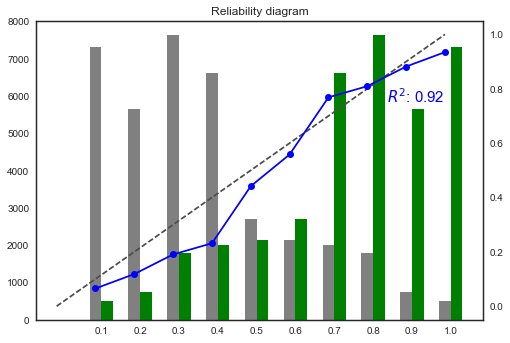

In [39]:
width = 0.03       # the width of the bars

fig, ax1 = plt.subplots()
rects1 = ax1.bar(bins[1:], negative_counts, width, color='grey')

rects2 = ax1.bar(bins[1:] + width, positive_counts, width, color='green')

# add some text for labels, title and axes ticks

ax1.set_title('Reliability diagram')
ax1.set_xticks(bins[1:] + width / 2)
ax1.set_xticklabels(bins[1:])
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

# ax1.legend((rects1[0], rects2[0]), ('Neg', 'Pos'), loc=5)

ax2 = ax1.twinx()
ax2.plot(bins, bins, ls="--", c=".3")
r2 = str(round(metrics.r2_score(bins[1:], pct_positive),2))
ax2.plot(bins[1:], binary_pct_positive, "-o", color='blue')
ax2.text(.85,.75,'$R^2$: {0}'.format(r2), color='blue', fontsize=15)


plt.show()